<a href="https://colab.research.google.com/github/hectormelo/Machine-Learning-Techniques/blob/main/Lab_6/Laboratorio_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024


# Laboratorio 6: Redes neuronales convolucionales (CNN)

Enlace para descargar los datos: https://drive.google.com/file/d/1707GeSxO9hO4KMOaRfc6t0KdiUlK91_0/view?usp=sharing

In [ ]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, MaxPooling2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer


In [ ]:
#Path donde se encuentran las imagenes
images_path = 'COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset'

El dataset contiene tres folder que corresponden a cada una de las categorias: Normal, Covid, Viral Pneumonia. La finalidad del problema es clasificar la imagen(RX de pulmón) en alguna de las categorias mencionadas anteriormente

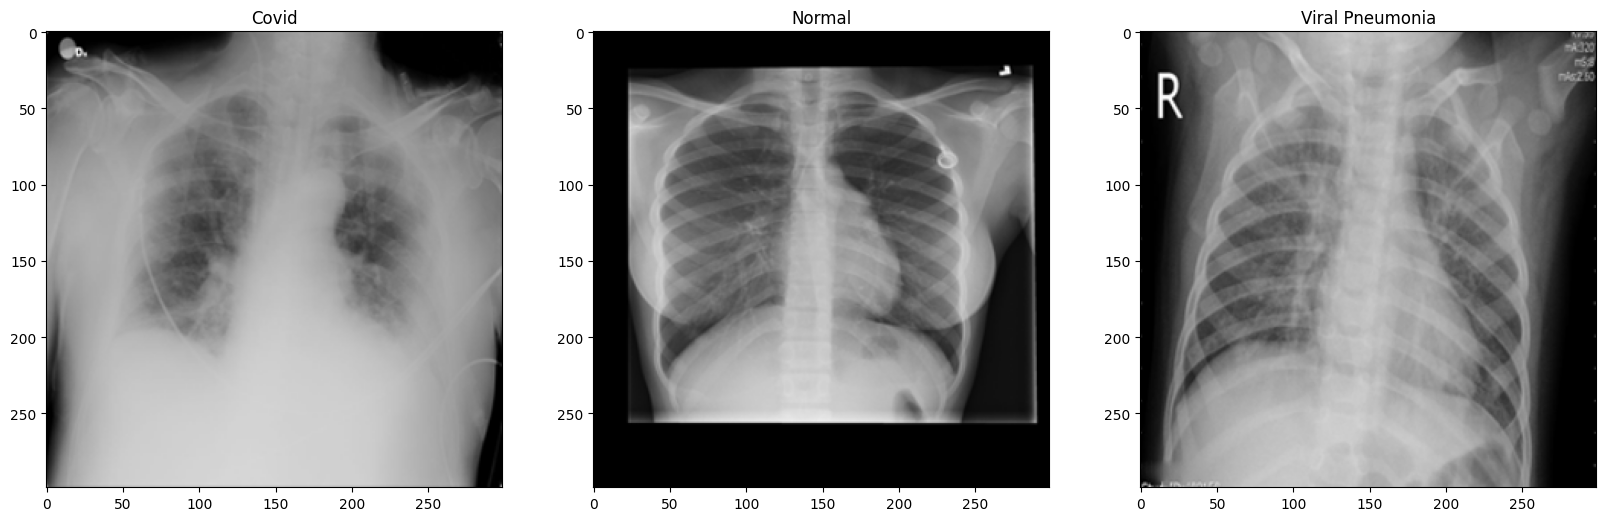

In [ ]:
#observamos las imágenes
plt.figure(figsize=(20,20))

plt.subplot(1, 3, 1)
plt.title('Covid')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\COVID\COVID-1.png'))

plt.subplot(1, 3, 2)
plt.title('Normal')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\\COVID-19_Radiography_Dataset\\Normal\\Normal-1.png'))

plt.subplot(1, 3, 3)
plt.title('Viral Pneumonia')
plt.imshow(cv2.imread('COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset\ViralPneumonia\Viral Pneumonia-1.png'))

plt.show()

## Preprocesamiento de los datos
Las imágenes se encuentran separadas por folders, donde cada folder corresponde a la clase. La idea es primero juntar todo en un solo dataset el cual tendrá dos columnas, una correspondiente al path de la imagen y otra a la etiqueta.

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(images_path) # leemos el directorio donde se encuentran las carpetas
for klass in classlist:
    classpath=os.path.join(images_path,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist: #accedemos a cada elemento de cada carpeta
            fpath=os.path.join(classpath,f) #creamos el path de la imagen
            filepaths.append(fpath) #agreamos el path a la lista
            labels.append(klass)   #agremaos la clase de la imagen a la lista

Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1) #juntamos ambas listas para crear nuestrp dataset
print (df.head())
print('distribucion de los datos'.center(60,'-'))
print (df['labels'].value_counts())

#A continuación se observa El datasets y la distribucion de los datos. Observamos que estos estan desbalanceados.

                                           filepaths labels
0  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
1  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
2  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
3  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
4  COVID-19_Radiography_Dataset\COVID-19_Radiogra...  COVID
-----------------distribucion de los datos------------------
Normal            10192
COVID              3616
ViralPneumonia     1345
Name: labels, dtype: int64


In [ ]:
#Manejo de desbalance de datos, solo tomaremos 1300 imagenes de cada uno

covid_df = shuffle(df.loc[df['labels'] == 'COVID']).head(1300).reset_index(drop=True)
normal_df = shuffle(df.loc[df['labels'] == 'Normal']).head(1300).reset_index(drop=True)
viral_df = shuffle(df.loc[df['labels'] == 'ViralPneumonia']).head(1300).reset_index(drop=True)
print(covid_df.shape, normal_df.shape, viral_df.shape) #Comprobamos que si quedaran todas las clases de la misma forma



(1300, 2) (1300, 2) (1300, 2)


Otra forma de balancear el dataset es usando Data Augmentation, esta estrategia nos permite generar infinidad de imagenes realizando variaciones como rotar, zoom, transponer, entre otros con el fin de enriquecer nuestro dataset.
A continuación se muestra un ejemplo de como realizar este aumento de datos y los resultados que genera.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)



In [ ]:
#Dataset resultante luego de balancear los datos
balanced_df = pd.concat([covid_df, normal_df, viral_df], ignore_index=True)
balanced_df = shuffle(balanced_df).reset_index(drop = True)
balanced_df.head()

,filepaths,labels
0,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,COVID
1,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,ViralPneumonia
2,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,Normal
3,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,ViralPneumonia
4,COVID-19_Radiography_Dataset\COVID-19_Radiogra...,Normal


In [ ]:
'''
Para los problemas implementando algoritmos de deep learning es recomendable generar un sub-set de validación,
esto con el fin de realizar una busqueda de hiperparametros y observar el comportamiento del modelo ante datos
externos al entrenamiento.
'''

X_train, X_test, y_train, y_test = train_test_split(balanced_df['filepaths'], balanced_df['labels'], test_size=0.30, random_state=33)

X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, train_size=0.5, random_state=34)


A continuación se muestran las imagenes que se generan implementando el método previamente visto. Para este ejercicio no lo usaremos, pero es bueno tenerlo en cuenta para poblemas en los que hayan pocos datos

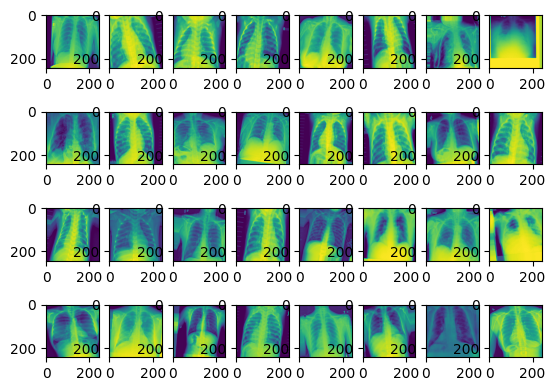

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [ ]:
print(X_train.shape, X_test.shape, X_val.shape) #observamos la dimensión de los diferentes sub-sets

(2730,) (585,) (585,)


## Pre-procesamiento de las imágenes
A continuación realizamos el procesamiento de las imágenes el cual consiste, para este caso, en pasar la imagen a escala de grises(un canal) y normalizar los pixeles de la imagen para que esten entre 0 y 1, posteriormente se le hace un reshape para segurarnos de que las dimensiones entre las imagenes sean correspondientes.

In [ ]:
IMG_SIZE =244

def preprocessig_data(data):
    X = []
    for img_path in data:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)#Pasamos la imagen a escala de grises
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0 # normalizamos los pixeles de la imagen

        X.append(img)


    X = np.array(X)
    X = X.reshape((-1, IMG_SIZE, IMG_SIZE, 1)) #Hacemos un reshape de las imagenes

    return X

In [ ]:
X_train = preprocessig_data(X_train)
X_val = preprocessig_data(X_val)

In [ ]:
'''
Para el target como esta en string, le hacemos primeramente un labelEncoder para pasarlo a numero y posteriormente
aplicamos el metodo 'to_categorical' el cual lleva a la variable a una forma similar a como sería si se le aplica
OneHotEncoding
'''
le = LabelEncoder()
#Primero tranformamos las clases en numeros
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

#Las llevamos a varias columnas, similar a OneHotEncoding
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)



# Modelo Base

Para nuestro modelo base usaremos un modelo secuencial compuesto por tres capas convolucionales, una capa densa con un dropout del 20% y una capa de salida con una función de activación softmax

In [ ]:
model_base = tf.keras.models.Sequential([

  Conv2D(30, kernel_size= (3,3), activation='relu', input_shape =(IMG_SIZE,IMG_SIZE,1)),
  MaxPooling2D(),

  Conv2D(20, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),

  Conv2D(20, kernel_size = (3,3), activation='relu'),
  MaxPooling2D(),

  Flatten(),
  Dense(100, activation='relu'),
  Dropout(0.2),

  Dense(3, activation= 'softmax')
])



Algunas veces nuestro modelo no presenta cambios o no mejora a los largo de las epocas es su función de costo o en el accuracy, una forma de detener el modelo cuando esto ocurre es implementar Early

documetación: https://keras.io/api/callbacks/early_stopping/

In [ ]:
'''
monitor: Hace referencia a la la variable que se tendra en cuenta para detener el modelo
para este caso usamos en valor de la función de perdida de el conjunto de validacion.

min_delta: cambio mínimo en la cantidad monitoreada para calificar como una mejora,
es decir, un cambio absoluto de menos de min_delta, contará como ninguna mejora.

paciencia: Número de épocas sin mejora tras las cuales se detendrá el entrenamiento.
'''
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

Compilamos nuentro modelo implementando el optimizar 'adam' y la función de pérdida 'CategoricalCrossentropy' por ser un problema de clasificación no binario. como métrica usamo el accuracy

In [ ]:
model_base.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

En la siguiente celda observamos el resumen de nuetro modelo y el numero de parámetros que este posee que en total son 1,577,743

In [ ]:
model_base.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 242, 242, 30)      300       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 121, 121, 30)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 119, 119, 20)      5420      
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 59, 59, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 57, 57, 20)        3620      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 28, 28, 20)     

Realizamos en el entrenamiento del modelo con un tamaño de batch de 40 y 10 epocas

In [ ]:
history_base = model_base.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=40, epochs = 10, callbacks=[early])

Epoch 1/10
69/69 [==============================] - 118s 2s/step - loss: 0.7402 - accuracy: 0.6586 - val_loss: 0.5838 - val_accuracy: 0.7658
Epoch 2/10
69/69 [==============================] - 115s 2s/step - loss: 0.4450 - accuracy: 0.8158 - val_loss: 0.4049 - val_accuracy: 0.8513
Epoch 3/10
69/69 [==============================] - 116s 2s/step - loss: 0.3728 - accuracy: 0.8465 - val_loss: 0.3809 - val_accuracy: 0.8513
Epoch 4/10
69/69 [==============================] - 117s 2s/step - loss: 0.3194 - accuracy: 0.8729 - val_loss: 0.2858 - val_accuracy: 0.8991
Epoch 5/10
69/69 [==============================] - 113s 2s/step - loss: 0.2445 - accuracy: 0.9059 - val_loss: 0.2958 - val_accuracy: 0.8735
Epoch 6/10
69/69 [==============================] - 115s 2s/step - loss: 0.2363 - accuracy: 0.9099 - val_loss: 0.3034 - val_accuracy: 0.8752
Epoch 7/10
69/69 [==============================] - 113s 2s/step - loss: 0.1784 - accuracy: 0.9319 - val_loss: 0.2610 - val_accuracy: 0.9043
Epoch 8/10
69

Observamos el comportamiento del modelo a lo largo de las epocas, observamos que el comportamiento del accuracy de entrenamiento sigue subiendo, mientras que parece que el de validación oscila entre 0.85 y 0.90.
Le dejamos al estudiante experimentar como sería el comportamiento de la grafica si se le agregan 7 epocas mas. ¿Habrá overfiting?

<AxesSubplot: xlabel='epochs', ylabel='accuracy'>

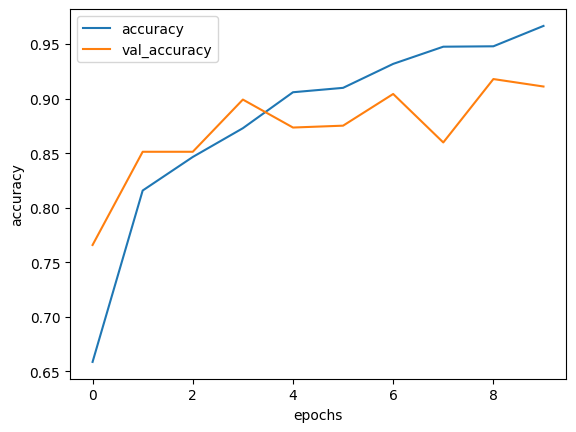

In [ ]:
df = pd.DataFrame(history_base.history)
df.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

Guardamos nuestro modelo para usarlo posteriormente al realizar el deploy del modelo

In [ ]:
model_base.save('conv_model_p.h5')


## Realizamos la evaluación con el conjunto de test

In [ ]:
X_test= preprocessig_data(X_test)
y_test = le.transform(y_test)
y_test = to_categorical(y_test)

Se puede observar que el comportamiento de los resultados en los tres sub-sets (train, validation, y test) es similar, por lo que nuestro modelo en general tiene un buen desempeño y envitó el sobre-entrenamiento.

In [ ]:
score = model_base.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]}\nTest Accuracy: {score[1]}')

19/19 [==============================] - 5s 261ms/step - loss: 0.2365 - accuracy: 0.9299
Test loss: 0.23650608956813812
Test Accuracy: 0.9299145340919495


## Modelo sin convolución
Quitamos la capa de convolución y solo aplanamos los datos con Flatten con el fin de ver las diferencias en los resultados, queda en el estudiante experimentar agregando mas capas profundas sobre el modelo y lograr mejores resultados, ¿Podrá superar el desempeño de la red convolucional?

In [ ]:
model_no_conv = tf.keras.models.Sequential([
  Flatten(input_shape =(IMG_SIZE,IMG_SIZE,1)),

  Dense(250, activation='relu'),
  Dropout(0.15),

  Dense(150, activation='relu'),
  Dropout(0.20),

  Dense(3, activation= 'softmax')
])

model_no_conv.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history_no_conv = model_no_conv.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=40, epochs = 10, callbacks=[early])

Epoch 1/10
69/69 [==============================] - 9s 116ms/step - loss: 6.1446 - accuracy: 0.5755 - val_loss: 1.3556 - val_accuracy: 0.6188
Epoch 2/10
69/69 [==============================] - 7s 97ms/step - loss: 0.8499 - accuracy: 0.6637 - val_loss: 0.6989 - val_accuracy: 0.7043
Epoch 3/10
69/69 [==============================] - 7s 101ms/step - loss: 0.7923 - accuracy: 0.6447 - val_loss: 0.6912 - val_accuracy: 0.6974
Epoch 4/10
69/69 [==============================] - 7s 102ms/step - loss: 0.6887 - accuracy: 0.6978 - val_loss: 0.5801 - val_accuracy: 0.7385
Epoch 5/10
69/69 [==============================] - 7s 103ms/step - loss: 0.7190 - accuracy: 0.6993 - val_loss: 0.6014 - val_accuracy: 0.7333
Epoch 6/10
69/69 [==============================] - 7s 104ms/step - loss: 0.7122 - accuracy: 0.6919 - val_loss: 0.5842 - val_accuracy: 0.7658
Epoch 7/10
69/69 [==============================] - 7s 104ms/step - loss: 0.7190 - accuracy: 0.6853 - val_loss: 0.5708 - val_accuracy: 0.7744
Epoch 8

<AxesSubplot: xlabel='epochs', ylabel='accuracy'>

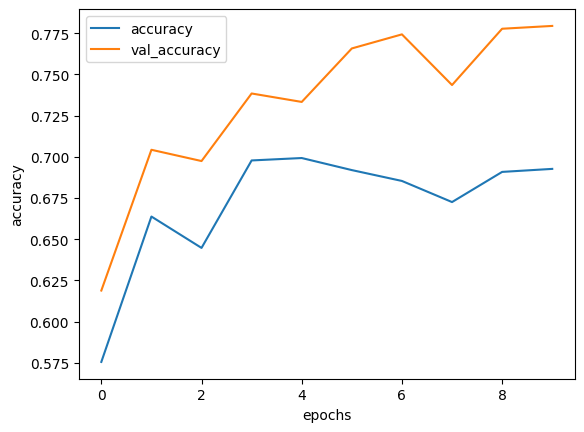

In [ ]:
df = pd.DataFrame(history_no_conv.history)
df.plot(y=['accuracy', 'val_accuracy'], xlabel='epochs', ylabel='accuracy')

In [ ]:
score_model_noConv = model_no_conv.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score_model_noConv[0]}\nTest Accuracy: {score_model_noConv[1]}')

19/19 [==============================] - 0s 22ms/step - loss: 0.5402 - accuracy: 0.7949
Test loss: 0.5402432084083557
Test Accuracy: 0.7948718070983887


In [ ]:
model_no_conv.save('model_no_conv.h5')

## Resultados de los modelos realizados

In [ ]:
#modelo_base
y_pred_base = model_base.predict(X_test)

y_pred_base = y_pred_base.argmax(axis=-1)

#modelo_no_conv
y_pred_noConv = model_no_conv.predict(X_test)
y_pred_noConv = y_pred_noConv.argmax(axis=-1)


19/19 [==============================] - 0s 19ms/step


Observaremos las diferentes metricas obtenidas para cada una de las clases y para cada uno de los modelos implementados

In [ ]:

Y_test = y_test.argmax(axis=-1)
print('Reporte para el modelo base construido'.center(60,'-'))
print(classification_report(Y_test, y_pred_base, target_names=['COVID', 'Normal', 'Viral_Pneumonia']))
print('Reporte para el modelo sin convolucion'.center(60,'-'))
print(classification_report(Y_test, y_pred_noConv, target_names=['COVID', 'Normal', 'Viral_Pneumonia']))


-----------Reporte para el modelo base construido-----------
                 precision    recall  f1-score   support

          COVID       0.90      0.96      0.93       204
         Normal       0.92      0.90      0.91       182
Viral_Pneumonia       0.98      0.93      0.96       199

       accuracy                           0.93       585
      macro avg       0.93      0.93      0.93       585
   weighted avg       0.93      0.93      0.93       585

-----------Reporte para el modelo sin convolucion-----------
                 precision    recall  f1-score   support

          COVID       0.71      0.92      0.80       204
         Normal       0.84      0.47      0.61       182
Viral_Pneumonia       0.88      0.96      0.92       199

       accuracy                           0.79       585
      macro avg       0.81      0.78      0.77       585
   weighted avg       0.81      0.79      0.78       585



## Realizar predicciones a una imagen en particular
Para realizar una predicción a una imagen en particular, cargaremos el modelo previamente guardado y crearemos una función que nos permita procesarla para poder introducirla a nuestro modelo

In [ ]:
model_load = load_model('conv_model_p.h5')

In [ ]:
def prep_img(img_path):
    IMG_SIZE =244
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0

    img = np.array(img)

    img = img.reshape(-1,img.shape[0], img.shape[1], 1)
    return img



In [ ]:
image_to_classify = prep_img('./COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-20.png')

In [ ]:
order = ['COVID', 'NORMAL', 'Pneumonia Viral']

In [ ]:
print(f'Clasification = {order[np.argmax(model_load.predict(image_to_classify))]}')

1/1 [==============================] - 0s 31ms/step
Clasification = COVID
